In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os


In [2]:
!kaggle datasets download naserabdullahalam/phishing-email-dataset

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
phishing-email-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with ZipFile('phishing-email-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('phishing-email-dataset')

In [4]:
data = pd.read_csv('phishing-email-dataset/phishing_email.csv')
data

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [5]:
data.shape

(82486, 2)

Text(0.5, 0, 'Label (0: Legitimate, 1: Phishing)')

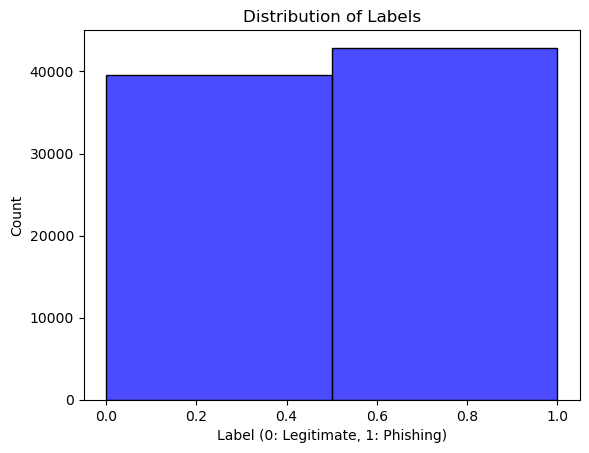

In [6]:
sns.histplot(data['label'], bins=2, color='blue', alpha=0.7)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Legitimate, 1: Phishing)')

In [7]:
!pip install langdetect

In [9]:
import re

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the 'text_combined' column
data['cleaned_text'] = data['text_combined'].apply(clean_text)
data.head()

,text_combined,label,cleaned_text
0,hpl nom may 25 2001 see attached file hplno 52...,0,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,0,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,0,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,0,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,0,hpl nom june see attached file hplno xls hplno...


In [10]:
# Feature engineering
data['text_length'] = data['cleaned_text'].apply(len)
data['num_special_chars'] = data['text_combined'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
data['num_uppercase'] = data['text_combined'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Display the updated dataframe
data.head()

,text_combined,label,cleaned_text,text_length,num_special_chars,num_uppercase
0,hpl nom may 25 2001 see attached file hplno 52...,0,hpl nom may see attached file hplno xls hplno xls,49,0,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,nom actual vols th forwarded sabrae zajac hou ...,880,0,0
2,enron actuals march 30 april 1 201 estimated a...,0,enron actuals march april estimated actuals ma...,109,0,0
3,hpl nom may 30 2001 see attached file hplno 53...,0,hpl nom may see attached file hplno xls hplno xls,49,0,0
4,hpl nom june 1 2001 see attached file hplno 60...,0,hpl nom june see attached file hplno xls hplno...,50,0,0


In [11]:
# Check for missing values
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
print(data.isnull().sum())

# Vectorize the cleaned_text column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Extract labels
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

text_combined        0
label                0
cleaned_text         0
text_length          0
num_special_chars    0
num_uppercase        0
dtype: int64
Training data shape: (65988, 5000)
Testing data shape: (16498, 5000)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)

# Train and evaluate Logistic Regression
logistic_model.fit(X_train, y_train)
logistic_preds = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_preds)
print(f"Logistic Regression Accuracy: {logistic_accuracy:.4f}")

# Train and evaluate Random Forest
random_forest_model.fit(X_train, y_train)
rf_preds = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Train and evaluate SVM
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Determine the best model
accuracies = {
    "Logistic Regression": logistic_accuracy,
    "Random Forest": rf_accuracy,
    "SVM": svm_accuracy
}
best_model = max(accuracies, key=accuracies.get)
print(f"Best Model: {best_model} with Accuracy: {accuracies[best_model]:.4f}")

Logistic Regression Accuracy: 0.9808
Random Forest Accuracy: 0.9844
SVM Accuracy: 0.9836
Best Model: Random Forest with Accuracy: 0.9844


In [ ]:
random_forest_model.predict()

In [20]:
test = tfidf_vectorizer.transform(["I hate you"])
random_forest_model.predict(test)

array([1], dtype=int64)

In [22]:
import joblib

phisingPredictor = joblib.dump(random_forest_model, 'phishing_predictor.pkl')
vectoriser = joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')